In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sentence_transformers import SentenceTransformer, util

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from xgboost import XGBClassifier

/home/kangcat/miniconda3/envs/documentation/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/kangcat/miniconda3/envs/documentation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kangcat/miniconda3/envs/documentation/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kangcat/miniconda3/envs/documentation/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `l

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### Preparing dataset
1. user_id
2. review_text
3. plot_synopsis
4. review_text embeddings
5. cosine similarity
6. ngram vector
7. review text length
   

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
directory_path = os.environ["DIR_PATH"]
df = pd.read_json(f"{directory_path}/dataset/cleaned_data.json")
df['label'] = df['is_spoiler'].astype(int)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (573913, 7)


,user_id,movie_id,review_text,is_spoiler,plot_synopsis,plot_summary,label
0,ur1898687,tt0111161,oscar year shawshank redemption write direct f...,1,andy dufresne tim robbins banker maine convict...,chronicle experience formerly successful banke...,1
1,ur0842118,tt0111161,shawshank redemption without doubt one brillia...,1,andy dufresne tim robbins banker maine convict...,chronicle experience formerly successful banke...,1
2,ur1285640,tt0111161,believe film best story ever tell film tell ti...,1,andy dufresne tim robbins banker maine convict...,chronicle experience formerly successful banke...,1
3,ur1003471,tt0111161,yes spoiler film emotional impact find hard wr...,1,andy dufresne tim robbins banker maine convict...,chronicle experience formerly successful banke...,1
4,ur0226855,tt0111161,heart extraordinary movie brilliant indelible ...,1,andy dufresne tim robbins banker maine convict...,chronicle experience formerly successful banke...,1


In [5]:
df['user_id'] = df['user_id'].str[2:].astype(int)
df = df[['user_id', 'review_text', 'plot_synopsis', 'label']]
df['review_text_length'] = df['review_text'].str.len()

df.head()

,user_id,review_text,plot_synopsis,label,review_text_length
0,1898687,oscar year shawshank redemption write direct f...,andy dufresne tim robbins banker maine convict...,1,2776
1,842118,shawshank redemption without doubt one brillia...,andy dufresne tim robbins banker maine convict...,1,709
2,1285640,believe film best story ever tell film tell ti...,andy dufresne tim robbins banker maine convict...,1,962
3,1003471,yes spoiler film emotional impact find hard wr...,andy dufresne tim robbins banker maine convict...,1,2148
4,226855,heart extraordinary movie brilliant indelible ...,andy dufresne tim robbins banker maine convict...,1,2735


In [6]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
print(f"Data split into train ({len(train_df)}) and test ({len(test_df)}) sets.")

Data split into train (459130) and test (114783) sets.


In [7]:
for obj in (train_df, test_df):
    obj.reset_index(drop=True, inplace=True)

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1016)')))"), '(Request ID: 8d234bd7-d138-4d77-afb0-66ff7a0acbaf)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /api/resolve-cache/models/sentence-transformers/all-MiniLM-L6-v2/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/modules.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1016)')))"), '(Request ID: 5795b83f-30bb-42c6-8a7f-65358e613408)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/sentence-transf

In [43]:
def embedd_to_vector(text):
    print("Encoding texts...")
    embeddings = model.encode(text.fillna('').tolist(), 
                              convert_to_tensor=True, show_progress_bar=True, device=device)
    print("Encoded.")
    return embeddings.cpu().numpy().tolist()

def concat_to_df(main_df, embedd_list, column_name):
    embedd_df = pd.DataFrame(embedd_list)
    num_dims = len(embedd_df.columns)
    if type(column_name) == list:
        new_names = [i for i in column_name]
    else:
        new_names = [f'{column_name}_{i}' for i in range(num_dims)]
    embedd_df.columns = new_names
    df = pd.concat([main_df, embedd_df], axis = 1)
    print(f"Finish concatenate: with dataframe {len(main_df)} and list {len(embedd_df)}")
    return df

In [10]:
train_review_embeddings = embedd_to_vector(train_df['review_text'])
train_synopsis_embeddings = embedd_to_vector(train_df['plot_synopsis'])

train_df = concat_to_df(train_df, train_review_embeddings, "dim")

Encoding texts...


Batches: 100%|███████████████████████████████████████████████████████████████████████████████| 14348/14348 [08:58<00:00, 26.63it/s]


Encoded.
Encoding texts...


Batches: 100%|███████████████████████████████████████████████████████████████████████████████| 14348/14348 [24:07<00:00,  9.91it/s]


Encoded.
Finish concatenate: with dataframe 459130 and list 459130


In [11]:
test_review_embeddings = embedd_to_vector(test_df['review_text'])
test_synopsis_embeddings = embedd_to_vector(test_df['plot_synopsis'])

test_df = concat_to_df(test_df, test_review_embeddings, "dim")

Encoding texts...


Batches: 100%|█████████████████████████████████████████████████████████████████████████████████| 3587/3587 [00:46<00:00, 77.65it/s]


Encoded.
Encoding texts...


Batches: 100%|█████████████████████████████████████████████████████████████████████████████████| 3587/3587 [00:56<00:00, 63.04it/s]


Encoded.
Finish concatenate: with dataframe 114783 and list 114783


In [12]:
print("Calculating similarities for training set...")
sim_scores_train = util.pairwise_cos_sim(train_review_embeddings, train_synopsis_embeddings)
train_df['sim_score_synopsis_review'] = sim_scores_train.flatten()

print("Calculating similarities for testing set...")
sim_scores_test = util.pairwise_cos_sim(test_review_embeddings, test_synopsis_embeddings)
test_df['sim_score_synopsis_review'] = sim_scores_test.flatten()

Calculating similarities for training set...
Calculating similarities for testing set...


In [13]:
vectorizer = TfidfVectorizer(
    max_features = 1000,
    stop_words = 'english',
    ngram_range=(1,2)
)

train_tfidf = vectorizer.fit_transform(train_df['review_text'])
test_tfidf = vectorizer.transform(test_df['review_text'])

print(f"Shape of TF-IDF matrices: Train = {train_tfidf.shape}, Test = {test_tfidf.shape}")

Shape of TF-IDF matrices: Train = (459130, 1000), Test = (114783, 1000)


In [44]:
feature_names = vectorizer.get_feature_names_out().tolist()

train_tfidf_df = concat_to_df(train_df, train_tfidf.toarray().tolist(), feature_names)
test_tfidf_df = concat_to_df(test_df, test_tfidf.toarray().tolist(), feature_names)

Finish concatenate: with dataframe 459130 and list 459130
Finish concatenate: with dataframe 114783 and list 114783


### Storing the dataset

In [ ]:
train_tfidf_df.to_json(f"{directory_path}/dataset/train_data.json",  orient="records", indent=4)
test_tfidf_df.to_json(f"{directory_path}/dataset/test_data.json",  orient="records", indent=4)

### Model

In [46]:
train_xg = train_tfidf_df.drop(columns= ['review_text', 'plot_synopsis'])
test_xg = test_tfidf_df.drop(columns= ['review_text', 'plot_synopsis'])
train_xg.head()

,user_id,label,review_text_length,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,...,writer,wrong,yeah,year,year ago,year old,yes,york,young,zombie
0,5291991,1,1821,-0.005757,-0.051729,-0.021550,-0.005745,-0.074771,0.078937,-0.069202,...,0.0,0.0,0.0,0.054831,0.0,0.0,0.000000,0.0,0.0,0.0
1,48053412,1,829,-0.002652,-0.056541,0.058831,-0.003095,0.043479,0.030117,0.054024,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,28438054,1,829,-0.017446,-0.091489,0.014513,-0.028227,-0.026655,0.060746,0.043278,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,35553121,0,182,-0.081114,0.030047,0.042871,0.093194,-0.001539,-0.004182,0.031489,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,14069613,0,1333,-0.051064,-0.072159,-0.044826,-0.012800,-0.006169,0.065184,0.030398,...,0.0,0.0,0.0,0.094936,0.0,0.0,0.070117,0.0,0.0,0.0


In [47]:
train = train_df.drop(columns= ['review_text', 'plot_synopsis'])
test = test_df.drop(columns= ['review_text', 'plot_synopsis'])
train.head()

,user_id,label,review_text_length,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,...,dim_375,dim_376,dim_377,dim_378,dim_379,dim_380,dim_381,dim_382,dim_383,sim_score_synopsis_review
0,5291991,1,1821,-0.005757,-0.051729,-0.021550,-0.005745,-0.074771,0.078937,-0.069202,...,0.016880,-0.055370,0.037996,0.061832,0.005916,0.155962,-0.013760,0.004469,0.077324,0.529475
1,48053412,1,829,-0.002652,-0.056541,0.058831,-0.003095,0.043479,0.030117,0.054024,...,-0.005599,0.075528,0.079341,-0.026007,-0.008913,0.128236,-0.015391,0.019221,-0.026087,0.344759
2,28438054,1,829,-0.017446,-0.091489,0.014513,-0.028227,-0.026655,0.060746,0.043278,...,0.033866,-0.012030,0.145682,0.003819,-0.071792,0.034811,-0.008870,-0.039890,-0.029504,0.407011
3,35553121,0,182,-0.081114,0.030047,0.042871,0.093194,-0.001539,-0.004182,0.031489,...,-0.003618,0.006736,0.047330,-0.101248,0.018851,0.084173,0.028484,0.019516,-0.022237,0.185389
4,14069613,0,1333,-0.051064,-0.072159,-0.044826,-0.012800,-0.006169,0.065184,0.030398,...,0.027673,-0.025575,0.043466,0.070013,0.032838,0.061937,0.032500,0.004026,-0.054742,0.518366


In [48]:
X_train = train_xg.drop(columns=["label"])
y_train = train_xg["label"]

X_test = test_xg.drop(columns=["label"])
y_test = test_xg["label"]

In [49]:
n = y_train.value_counts()
pos_weight = round(n[0]/n[1],2)

print(f"Positive Weight: {pos_weight}")

Positive Weight: 2.8


In [101]:
clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight = 2.8,
    device = "cuda"
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluation
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)
print("Classification Report on test set:")
print(classification_report(y_test, pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     84598
           1       0.44      0.72      0.54     30185

    accuracy                           0.68    114783
   macro avg       0.65      0.69      0.65    114783
weighted avg       0.76      0.68      0.70    114783



In [104]:
importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 10 Feature Importances")
print(importances.head(10))

Top 10 Feature Importances
spoiler                      0.052071
review_text_length           0.042683
dim_223                      0.038659
dim_319                      0.034873
user_id                      0.022272
kill                         0.014635
sim_score_synopsis_review    0.012280
dim_49                       0.009248
die                          0.008796
end                          0.008715
dtype: float32


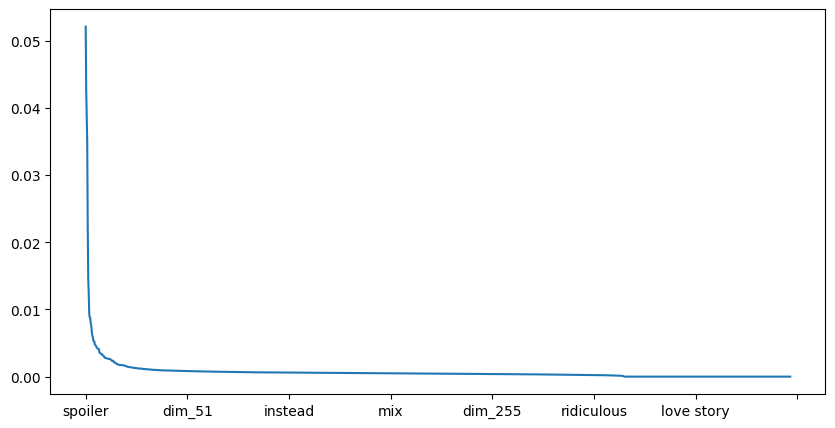

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5)) 
importances.plot()
plt.show()